# <center>Lesson 7: Advanced data containers</center>
### <center>yt user/developer workshop, July 2025</center>

# Covered in this lesson:
- field parameters: allows to parametrize fields for a given container
- boolean operators: create new data container from combination of others,
- cut regions: subsample a data container based on the value of (a) field(s),
- slices and cuts: go from 3 to 2D,
- covering grids: special containers that return gridded data,

## Previous concepts:
* **field**: an array of values describing a quantity associated with each element in the `dataset`. This is the data we want. Examples: the gas densities of the grid cells, the positions of the particles, the brightness of the pixels.
* **data container**: an object containing one or more elements of a `dataset`. It provides access to `fields` for all the elements it contains.

In [ ]:
import yt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ds = yt.load_sample("output_00080")

# This could be taken from a file, or calculated. For this tutorial, let's assume those
center = ds.arr([0.752022, 0.76841606, 0.7971783], "unitary")
Rvir = ds.quan(161, "kpc")
sp = ds.sphere(center, 4 * Rvir)

In [ ]:
# Alternatively, this is a larger and more interesting dataset
ds = yt.load("../../../output_00239")
*center, Rvir = np.loadtxt("../../../output_00239/halo_qties.txt", delimiter=",")
center = ds.arr(center, "code_length")
Rvir = ds.quan(Rvir, "unitary")
sp = ds.sphere(center, 4 * Rvir)

Let's take a gander at our data:

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.annotate_sphere(center, Rvir)
p

**Exercise**: reproduce this plot
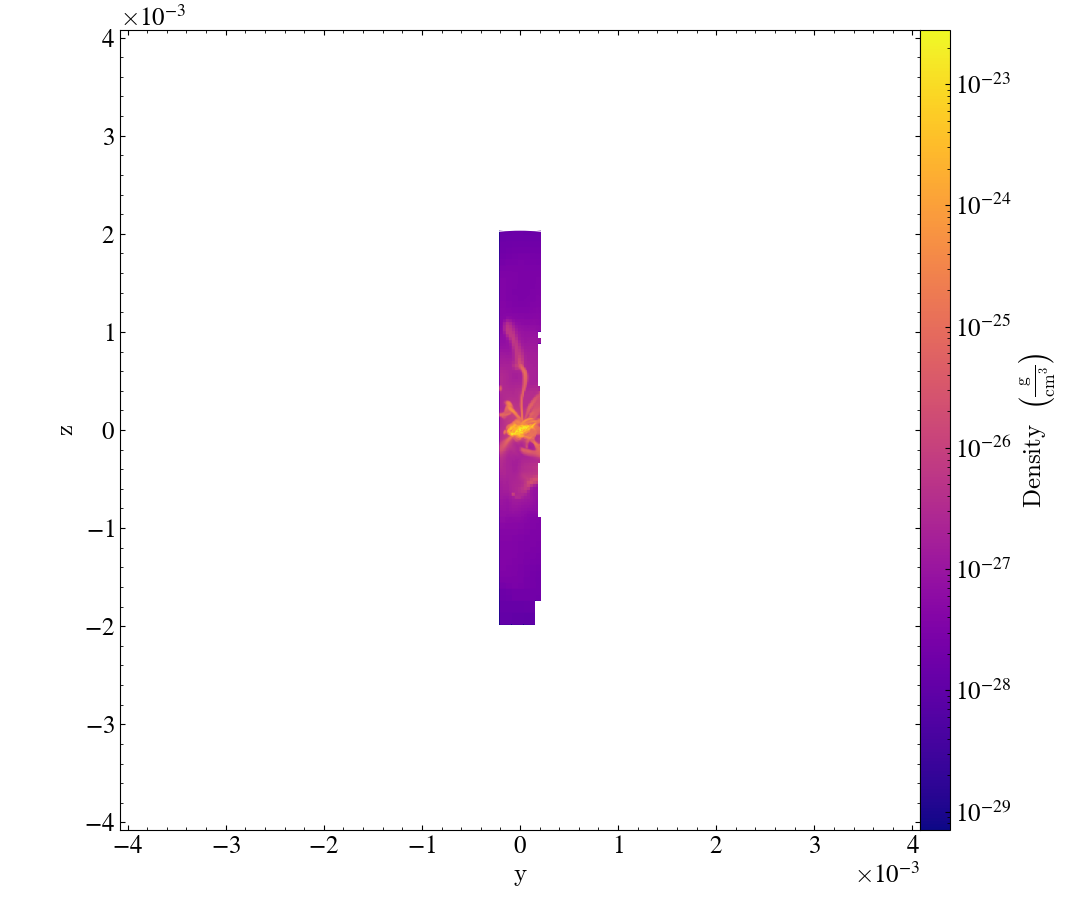

# Derived fields and data containers

In [ ]:
# Open question: what's should the center of this object be?
sp = ds.sphere(center, Rvir)

In [ ]:
# Follow-up: what should these return?
sp["index", "cylindrical_theta"], sp["index", "spherical_radius"]

In [ ]:
p = yt.SlicePlot(ds, "x", "cylindrical_theta", data_source=sp, center=sp.center, width=2*Rvir)
p.set_log("cylindrical_theta", False)

In [ ]:
p = yt.SlicePlot(ds, "z", "cylindrical_theta", data_source=sp, center=sp.center, width=2*Rvir)
p.set_log("cylindrical_theta", False)

Introducing `field parameters`.

In [ ]:
sp.field_parameters

In [ ]:
sp = ds.sphere(center, Rvir)
sp.set_field_parameter("normal", [1, 0, 0])

In [ ]:
p = yt.SlicePlot(ds, "x", "cylindrical_theta", data_source=sp, center=sp.center, width=2*Rvir)
p.set_log("cylindrical_theta", False)

In [ ]:
p = yt.SlicePlot(ds, "z", "cylindrical_theta", data_source=sp, center=sp.center, width=2*Rvir)
p.set_log("cylindrical_theta", False)

In [ ]:
sp.get_field_parameter

In [ ]:
def my_field(field, data):
    rho_mean = data.get_field_parameter("mean_density")
    return np.ones_like(data["index", "ones"]) * rho_mean

ds.add_field(("gas", "mean_density"), function=my_field, sampling_type="cell", units="mp/cm**3")

In [ ]:
sp = ds.sphere(center, Rvir, field_parameters={"mean_density": ds.quan(1, "mp/cm**3")})
sp["gas", "mean_density"]

In [ ]:
sp.clear_data()
sp.set_field_parameter("mean_density", ds.quan(2, "mp/cm**3"))
sp["gas", "mean_density"]

# More advanced containers

### Boolean data objects

We can combine data containers together with boolean operations. Supported operators are `&`, `|` and `~` (and, or, not). The result is a new data container that contains only the elements that match the boolean condition.

In [ ]:
sp_halo = ds.sphere(center, Rvir * 2)
sp_disk = ds.sphere(center, Rvir * 0.1)

# Let's define the CGM as anything between 0.1 and 2 Rvir
sp_CGM = sp_halo - sp_disk

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp_CGM,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.set_zlim(("gas", "density"), 0.5e-29, 2e-23)
p.annotate_sphere(center, 2 * Rvir, circle_args={"color": "gray", "ls": "--"})
p.annotate_sphere(center, Rvir / 10, circle_args={"color": "k", "ls": "-."})
p

**Exercise**: reproduce this plot
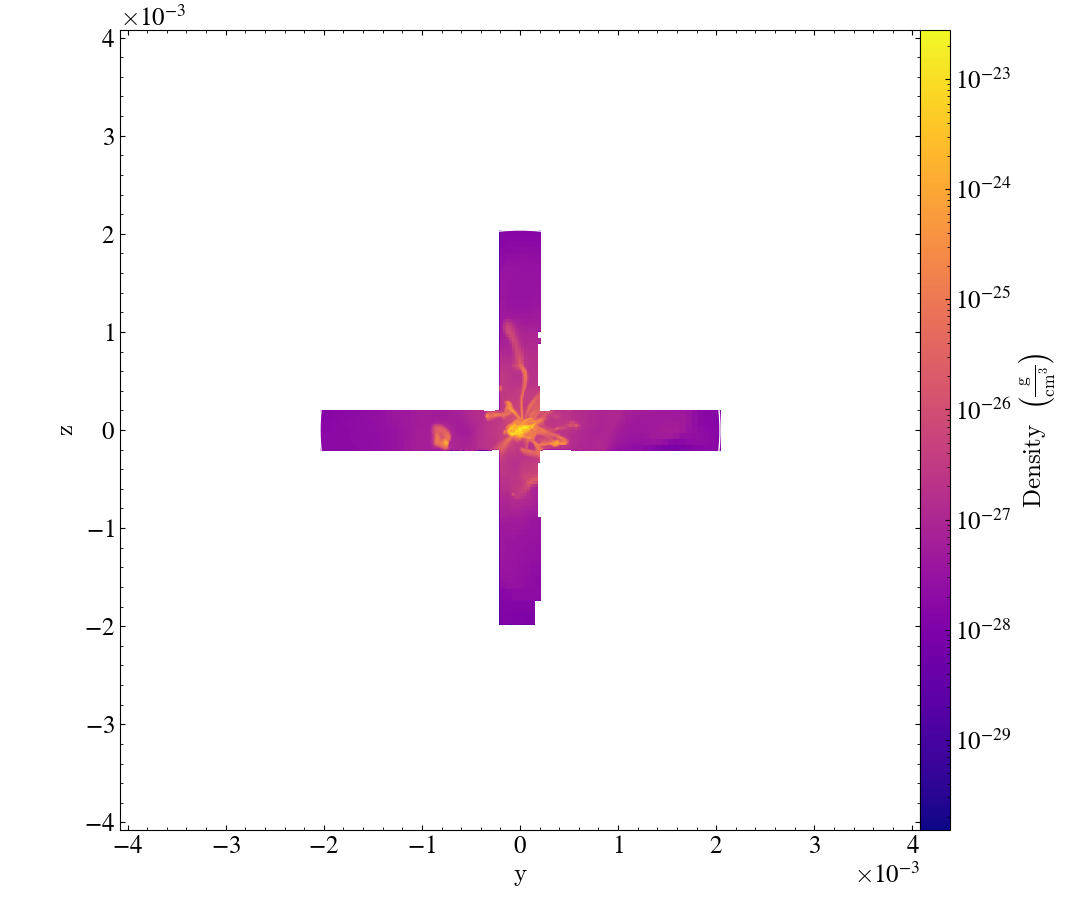

### Cut region

Cut regions are a more general solution to filtering mesh fields. The output of a cut region is an entirely new data object, which can be treated like any other data object to generate images, examine its values, etc.

Let's exemplify by looking into the structure of the circum-galactic medium (CGM) of the galaxy above.

In [ ]:
pp = yt.PhasePlot(
    sp_CGM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_unit("density", "mp/cm**3")
pp

We can create cut regions using the `include_above`, `include_below`, and `include_between` methods (or similarly `exclude_*`). Internally, these methods use the more flexible `cut_region` method.

In [ ]:
sp_cold_CGM = sp_CGM.include_below("temperature", 2e4)
pp = yt.PhasePlot(
    sp_cold_CGM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_ylim(None, 1e7)

In [ ]:
p = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    data_source=sp_cold_CGM,
    center=sp.center,
    width=4 * Rvir,
    weight_field="density",
)
p.set_zlim(("gas", "density"), 0.5e-29, 2e-23)
p.annotate_sphere(center, 2 * Rvir, circle_args={"color": "gray", "ls": "--"})
p.annotate_sphere(center, Rvir / 10, circle_args={"color": "k", "ls": "-."})
p

In [ ]:
sp_CGM_wo_ISM = sp_CGM.cut_region(
    ["(obj['density'] / obj['temperature']) < (1e-25 / 1e4)"]
)

pp = yt.PhasePlot(
    sp_CGM_wo_ISM,
    "density",
    "temperature",
    "cell_mass",
)
pp.set_unit("cell_mass", "Msun")
pp.set_xlim(None, 1e-22)
pp.set_ylim(30, None)

**Exercise**: reproduce this plot
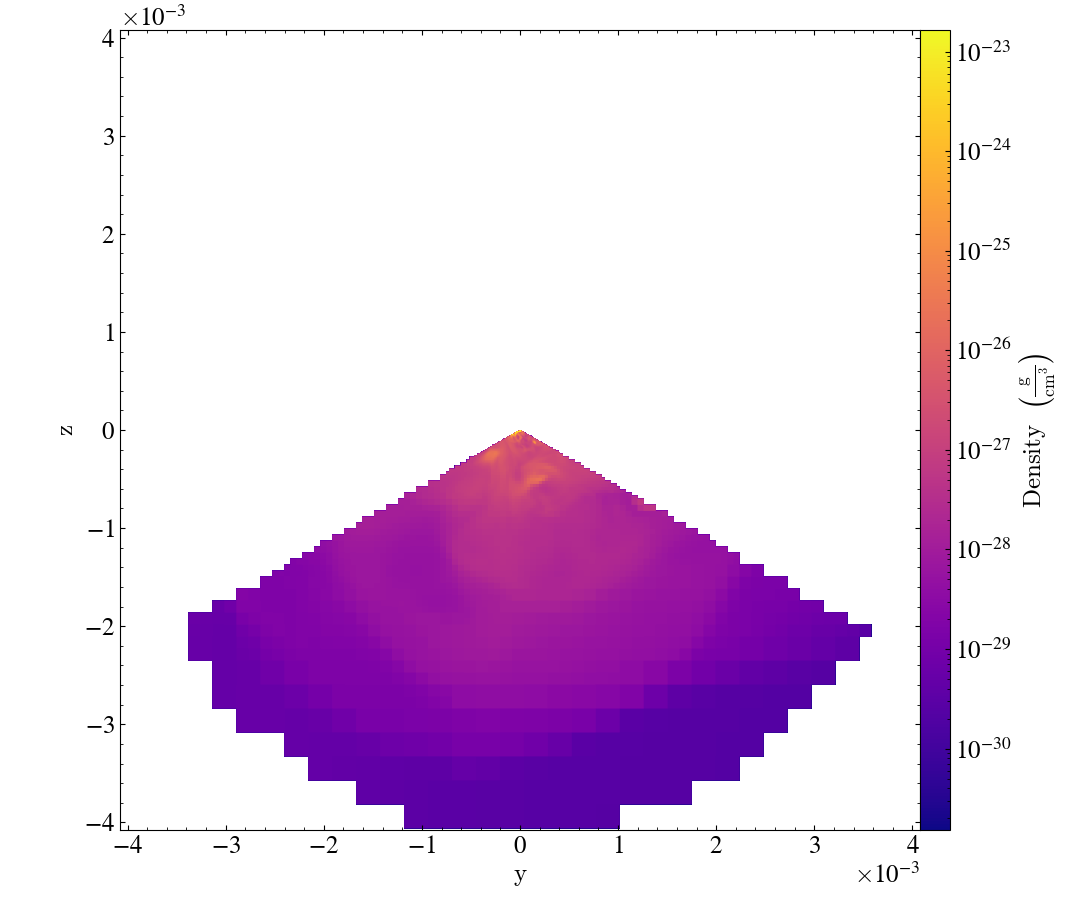

**Exercise**: reproduce this plot
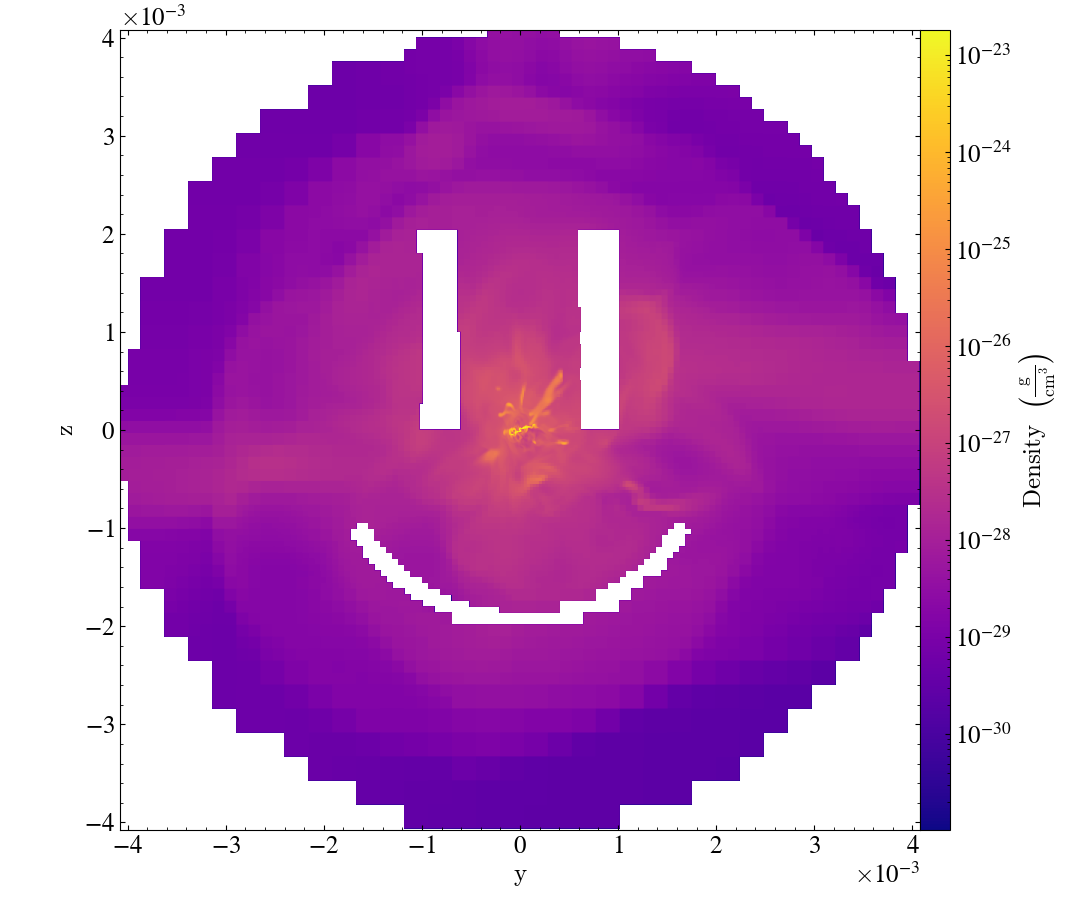

### (Iso-)Surfaces

We can extract surfaces, which yields a regular data container.

In [ ]:
surf = ds.surface(sp_disk, ("gas", "density"), (1, "mp/cm**3"))

In [ ]:
# Unfortunately, phase plots cannot be made with a surface data container yet.
# Let's do it manually
fig, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True, constrained_layout=True)
axes[0].hist2d(
    surf["gas", "density"].to("mp/cm**3"),
    surf["gas", "temperature"].to("K"),
    bins=(np.geomspace(1e-1, 1e1, 100), np.geomspace(1e1, 1e8, 100)),
    weights=surf["gas", "cell_mass"].to("Msun").d,
    norm=plt.matplotlib.colors.LogNorm(),
)
axes[0].set(
    xlabel=r"Density [$\mathrm{m_p/cm^3}$]",
    ylabel=r"Temperature [$\mathrm{K}$]",
    xscale="log",
    yscale="log",
)

axes[1].hist2d(
    surf["gas", "metallicity"],
    surf["gas", "temperature"].to("K"),
    bins=(np.geomspace(1e-3, 1, 100), np.geomspace(1e1, 1e8, 100)),
    weights=surf["gas", "cell_mass"].to("Msun").d,
    norm=plt.matplotlib.colors.LogNorm(),
)
axes[1].set(
    xlabel=r"Metallicity",
    xscale="log",
    yscale="log",
)
fig.align_xlabels(axes)

The surface also has a `.triangles` attribute that allow to render this in 3D. See the section on [complex plots](https://yt-project.org/doc/cookbook/complex_plots.html#plotting-isocontours) for more details.

In [ ]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Color this isodensity surface according to the log of the temperature field
colors = yt.apply_colormap(np.log10(surf["gas", "temperature"]), cmap_name="hot")

# Create a 3D matplotlib figure for visualizing the surface
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
p3dc = Poly3DCollection((surf.triangles - center).to("kpc"), linewidth=0.0)

# Set the surface colors in the right scaling [0,1]
p3dc.set_facecolors(colors[0, :, :] / 255.0)
ax.add_collection(p3dc)

# Let's keep the axis ratio fixed in all directions by taking the maximum
# extent in one dimension and make it the bounds in all dimensions
max_extent = (surf.vertices.max(axis=1) - surf.vertices.min(axis=1)).max()
bounds = np.zeros([3, 2])
bounds[:, 0] = -max_extent.to("kpc") / 2
bounds[:, 1] = +max_extent.to("kpc") / 2
ax.auto_scale_xyz(bounds[0, :], bounds[1, :], bounds[2, :])
ax.set(
    xlabel="x [kpc]",
    ylabel="y [kpc]",
    zlabel="z [kpc]",
    title="Isodensity surface colored by log10(temperature)",
)

### Slices, cuts and projections

While slices are often used for visualization, they can be useful for other operations as well. yt regards slices as multi-resolution objects. They are an array of cells that are not all the same size; it only returns the cells at the highest resolution that it intersects.

In [ ]:
slice = ds.slice("x", center[0], data_source=sp_CGM, center=sp.center)
# Alternative syntax:
# slice = ds.r[center[0], :, :]

In [ ]:
slice["density"], slice["temperature"]

Note that slices do yields cells in the simulation, not a projection onto a regular 2D grid!

In [ ]:
slice["dx"].min().to("pc"), slice["dx"].max().to("pc")

Similarly, we can create an off-axis slice using `cutting` instead of `slice`.

In [ ]:
cut = ds.cutting([0.1, 0.2, 0.3], center, data_source=sp_CGM)

In [ ]:
cut["density"], cut["temperature"], cut["dx"].min().to("pc"), cut["dx"].max().to("pc")

Finally, we can also create projections. Those implement a line integration along the provided direction and return a representation of the integrated field.

In [ ]:
proj = ds.proj(("gas", "density"), "x", data_source=sp_CGM)
proj_wei = ds.proj(
    ("gas", "density"), "x", data_source=sp_CGM, weight_field="dx"
)
proj_std = ds.proj(
    ("gas", "density"), "x", data_source=sp_CGM, weight_field="dx", moment=2
)
proj_max = ds.proj(("gas", "density"), "x", data_source=sp_CGM, method="max")

In [ ]:
(
    np.nanmax(proj["temperature"]),
    np.nanmax(proj_wei["temperature"]),
    np.nanmax(proj_std["temperature"]),
    np.nanmax(proj_max["temperature"]),
)

### Fixed resolution buffers (FRBs)
Very commonly, we want to project or slice a field through a specific point in space and project onto a regular 2D grid.

In [ ]:
L = center - 2 * Rvir
R = center + 2 * Rvir
# Create a 1024x1024 pixel FRB centered on the center of the halo
frb = ds.r[center[0], L[1] : R[1] : 1024j, L[2] : R[2] : 1024j]

In [ ]:
plt.imshow(
    frb["gas", "density"].to("mp/cm**3").d,
    origin="lower",
    cmap="magma",
    norm=plt.matplotlib.colors.LogNorm(),
)

We can also obtain a fixed resolution buffer from a slice or a projection

In [ ]:
containers = (slice, proj, proj_wei, proj_std, proj_max)
fig, axes = plt.subplots(
    ncols=len(containers),
    figsize=(len(containers) * 3, 3),
    constrained_layout=True,
    sharex=True,
    sharey=True,
)

for ax, container, title in zip(
    axes,
    containers,
    (
        "Slice",
        "Projection",
        "Weighted Projection",
        "Standard Deviation Projection",
        "Max Projection",
    ),
):
    im = ax.imshow(
        container.to_frb(4 * Rvir, 1024, center=center)["gas", "density"].d,
        origin="lower",
        cmap="magma",
        norm=plt.matplotlib.colors.LogNorm(),
    )
    ax.set_title(title)
    ax.set_xlabel("y [kpc]")

### Arbitrary grids
This allows to project *everything* onto an arbitrary regular grid with a fixed resolution. It needs not be aligned with the simulation grid. Note that this may be expensive, as yt needs to interpolate the data onto the new grid. You can see it as the 3D equivalent of a fixed resolution buffer.

In [ ]:
grid = ds.r[L[0]:R[0]:256j, L[1]:R[1]:256j, L[2]:R[2]:256j]
# or equivalently
grid = ds.arbitrary_grid(L, R, (256, 256, 256))

In [ ]:
grid["gas", "density"].shape

In [ ]:
plt.imshow(grid["gas", "density"].sum(axis=2).T, origin="lower", cmap="magma", norm=plt.matplotlib.colors.LogNorm())

### Covering grids
As seen above, interpolating data onto an arbitrary grid can be expensive. If possible, consider using a (smooth) covering grid instead. This is similar in spirit, except the covering grid is aligned with the simulation grid and only interpolates the data onto the new grid.

In [ ]:
sp_CGM["index", "grid_level"].max()

In [ ]:
smoothed_grid = ds.smoothed_covering_grid(level=6, left_edge=L, dims=(256, 256, 256), num_ghost_zones=1)
grid = ds.covering_grid(level=6, left_edge=L, dims=(256, 256, 256))

In [ ]:
grid["gas", "density"].shape

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8), constrained_layout=True)
for ax in axes:
    ax.axis("off")

kwa = {"origin": "lower", "cmap": "magma", "norm": plt.matplotlib.colors.LogNorm()}
axes[0].imshow(grid["gas", "density"].sum(axis=2).T, **kwa)
axes[1].imshow(smoothed_grid["gas", "density"].sum(axis=2).T, **kwa)
axes[0].set_title("Arbitrary grid")
axes[1].set_title("Smoothed covering grid")

Having a uniform grid can be useful, for example to compute the power spectrum or to compute finite differences that are more easily expressed on a uniform grid.

In [ ]:
# Compute the velocity dispersion in cubes of size [3x3x3] pixels
vtot = np.zeros((*smoothed_grid["velocity_x"].shape, 3))

for i in range(3):
    for j in range(3):
        for k in range(3):
            vtot[..., 0] += np.roll(smoothed_grid["velocity_x"].d, (i-1, j-1, k-1))
            vtot[..., 1] += np.roll(smoothed_grid["velocity_y"].d, (i-1, j-1, k-1))
            vtot[..., 2] += np.roll(smoothed_grid["velocity_z"].d, (i-1, j-1, k-1))
vtot /= 27

vvar = np.zeros(smoothed_grid["velocity_x"].shape)
for i in range(3):
    for j in range(3):
        for k in range(3):
            vvar += (np.roll(smoothed_grid["velocity_x"].d, (i-1, j-1, k-1)) - vtot[..., 0]) ** 2
            vvar += (np.roll(smoothed_grid["velocity_y"].d, (i-1, j-1, k-1)) - vtot[..., 1]) ** 2
            vvar += (np.roll(smoothed_grid["velocity_z"].d, (i-1, j-1, k-1)) - vtot[..., 2]) ** 2
vvar = ds.arr(vvar / 27, smoothed_grid["velocity_x"].units**2)

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
IM = axes[0].imshow(np.sqrt(vvar).to("km/s").mean(axis=1).T, origin="lower", cmap="viridis", norm=plt.matplotlib.colors.LogNorm())
CB = plt.colorbar(IM, ax=axes[0])
CB.set_label(r"$\sigma_v$ [km/s]")

IM = axes[1].imshow(smoothed_grid["gas", "density"].sum(axis=1).T, origin="lower", cmap="magma", norm=plt.matplotlib.colors.LogNorm())
CB = plt.colorbar(IM, ax=axes[1])
CB.set_label(r"$\rho$ [g/cm$^3$]")

### Streamlines
Unfortunately doesn't work for oct datasets yet.

In [ ]:
from yt.visualization.api import Streamlines

# Load the dataset
ds = yt.load_sample("IsolatedGalaxy")

# Define c: the center of the box, N: the number of streamlines,
# scale: the spatial scale of the streamlines relative to the boxsize,
# and then pos: the random positions of the streamlines.
c = ds.domain_center
N = 100
scale = ds.domain_width[0]
pos_dx = np.random.random((N, 3)) * scale - scale / 2.0
pos = c + pos_dx

# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = Streamlines(
    ds,
    pos,
    ("gas", "velocity_x"),
    ("gas", "velocity_y"),
    ("gas", "velocity_z"),
    length=1.0 * Mpc,
    get_magnitude=True,
)
streamlines.integrate_through_volume()